# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [52]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

# import torch.optim as optim
# import torch.nn.functional as F

def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../data'
embeddings_path = '../word_embeddings'


In [2]:
if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

print(DEVICE)

cuda:0


In [3]:
h_params = {
    'model': 'None'
    , 'batch_size': 128
    , 'embedding_dimensions': 50
}

In [4]:
# Download the pre-trained model for word_embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip 1/glove.6B.zip

## Raw Data

### Loading

Load the data into pandas dataframes

In [5]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [6]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

train_data = train_data.drop('par_id', axis=1)
test_data = test_data.drop('par_id', axis=1)

In [7]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [22]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

## Pre-Processing

In [23]:
class LabelledDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use is_patronizing
        label = {'is_patronizing': self.data['is_patronizing'].iloc[idx]}

        return data, label
    
class WithheldDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        return data

train_loader = DataLoader(dataset=LabelledDataset(train_data), batch_size=h_params['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=WithheldDataset(train_data), batch_size=h_params['batch_size'], shuffle=True)

In [12]:
# # Define Embedding Class
# class Encoder(nn.Module):
#     def __init__(self, vocab_size, embedding_dimension):
#         super(Encoder, self)
#         # create embedding object to store mappings from words to embedded vectors
#         self.tokenEmbeddings = nn.Embedding(num_embeddings=vocab_size
#                                           , embedding_dim=embedding_dimension
#                                           , padding_idx=0)
    
#     def forward(self, x):
#         """Generates the embeddings for each word in the input, of size: (batch_size, max_length of training sample)"""
#         embedded = self.embedding(x)
#         embedded = embedded.unsqueeze(1)

#         return embedded

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [45]:
X = train_data['text']
y = train_data['is_patronizing']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8374,)
y_train shape: (8374,)
X_test shape: (2094,)
y_test shape: (2094,)


## Model

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing = False,               # otherwise for me it doesn't run at all
                                      use_multiprocessing_for_evaluation = False # otherwise for me it doesn't run at all
                                      )

task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=DEVICE)

# train model
task1_model.train_model(pd.concat([X_train, y_train], axis=1))

In [58]:
# run predictions
y_pred, _ = task1_model.predict(X_test.tolist())

100%|██████████| 21/21 [00:05<00:00,  3.57it/s]


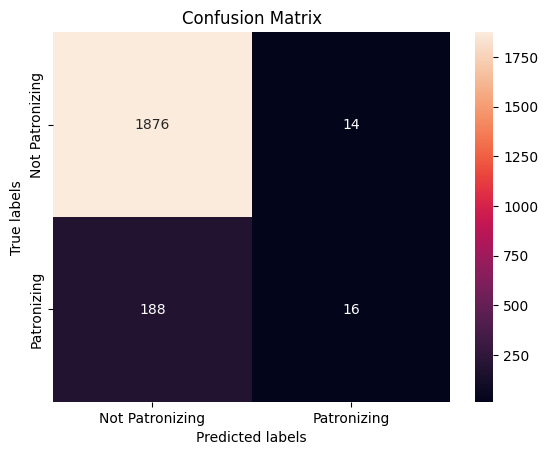

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

set(y_pred)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1]) 

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing']); ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing']);

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1890
           1       0.53      0.08      0.14       204

    accuracy                           0.90      2094
   macro avg       0.72      0.54      0.54      2094
weighted avg       0.87      0.90      0.87      2094



In [133]:
# Get one random sample from the test data
random_index = X_test.sample(n=1).index.values[0]

while random_index not in train_data.index:
    random_index = X_test.sample(n=1).index.values[0]

# Extract random sample
tdf = train_data.loc[[random_index]][['text', 'is_patronizing']]
test_paragraph, real_label = tdf['text'].values[0], tdf['is_patronizing'].values[0]

# Get model prediction
predicted_label, raw_outputs = task1_model.predict([tdf['text'].values[0]])
# predicted_label = task1_model.predict(tdf['text'].values[0])

print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
print(f"\tReal Label:      {real_label}")
print(f"\tModel Prediction:{predicted_label[0]}")

100%|██████████| 1/1 [00:00<00:00, 85.42it/s]

=== Paragraph example ===
While the scale of waste is astonishing in the western world , the plight of the poor families in the uk being " literally " forced to rely on food banks than those suffering in african villages and refugee camps , is a sad story . but it is a true story .
	Real Label:      1
	Model Prediction:0


In [14]:
# # Load Pre-trained Embeddings from GloVe

# word2idx = 

# w2i = [] # word2index
# i2w = [] # index2word
# wvecs = [] # word vectors

# # this is a large file, it will take a while to load in the memory!
# with codecs.open(f'glove.6B.{h_params['embedding_dimensions']}d.txt', 'r','utf-8') as f:
#   index = 0
#   for line in tqdm(f.readlines()):
#     # Ignore the first line - first line typically contains vocab, dimensionality
#     if len(line.strip().split()) > 3:

#       (word, vec) = (line.strip().split()[0],
#                      list(map(float,line.strip().split()[1:])))

#       wvecs.append(vec)
#       w2i.append((word, index))
#       i2w.append((index, word))
#       index += 1

# w2i = dict(w2i)
# i2w = dict(i2w)
# wvecs = np.array(wvecs)

